In [1]:
import os
import sys
import boto3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv import load_dotenv
from sklearn.cluster import KMeans

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import connect_to_redshift

In [2]:
# removing warning messages
warnings.filterwarnings("ignore")

In [3]:
# Loading my .env file
load_dotenv()

True

In [4]:
# defining redshift credentials
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [5]:
# establishing redshift connection
rs_connection = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = """select *
           from bootcamp.online_transactions_fixed
        """

In [7]:
ot = pd.read_sql(query, rs_connection)

In [8]:
print(f"There are {ot.duplicated().sum()} duplicated rows in the dataset")

There are 0 duplicated rows in the dataset


In [9]:
ot.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,2010-12-01 08:45:00,1.25,u12583,France,30.00
1,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50
2,536381,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90
3,536384,22469,HEART OF WICKER SMALL,40,2010-12-01 09:53:00,1.45,u18074,United Kingdom,58.00
4,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,1,2010-12-01 09:56:00,19.95,u1742,United Kingdom,19.95


In [10]:
print(ot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   quantity           399841 non-null  int64         
 4   invoice_date       399841 non-null  datetime64[ns]
 5   price              399841 non-null  float64       
 6   customer_id        399841 non-null  object        
 7   country            399841 non-null  object        
 8   total_order_value  399841 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB
None


In [11]:
ot.describe()

,quantity,price,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,12.224359,2.952914,20.716904
std,250.788860,7.317593,425.471765
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.250000
50%,5.000000,1.950000,11.580000
75%,12.000000,3.750000,19.500000
max,80995.000000,1599.260000,168469.600000


In [12]:
ot.describe(include=object)

,invoice,stock_code,description,customer_id,country
count,399841,399841,399841,399841,399841
unique,21791,3679,3644,4363,37
top,576339,85123A,CREAM HANGING HEART T-LIGHT HOLDER,u17841,United Kingdom
freq,542,2065,2065,7800,356158


### Let's explore the outliers

<Axes: >

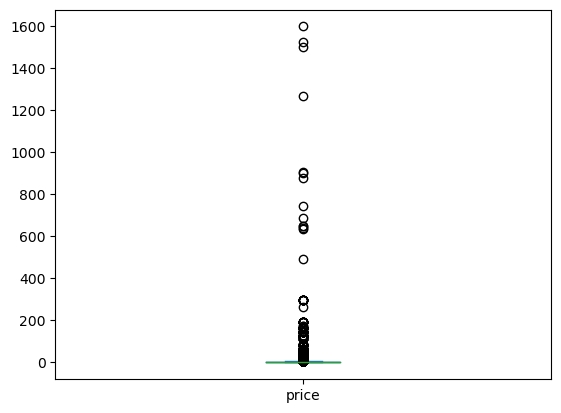

In [13]:
ot['price'].plot.box()

### It is clear that there are outliers on the price column. Let's check how many transactions are with price equal to zero

In [14]:
# Number of transactions with price equal to zero
n_price_zero = ot[ot['price'] == 0].shape[0]
print(f"There are {n_price_zero} transactions with price zero. That represents {round(n_price_zero * 100 / ot.shape[0], 2)} % of the data, therefore they are gonna be removed from the dataset.")

There are 34 transactions with price zero. That represents 0.01 % of the data, therefore they are gonna be removed from the dataset.


In [15]:
ot.drop(ot[ot['price'] == 0].index, axis=0, inplace=True)
ot.reset_index(inplace=True, drop=True)

In [16]:
# Let's start by exploring the outliers in the price column
_, mean_price, std_price, min_price, Q1_price, Q2_price, Q3_price, max_price = ot.price.describe()
IQR_price = Q3_price - Q1_price
low_lim_price = Q1_price - 1.5 * IQR_price
up_lim_price = Q3_price + 1.5 * IQR_price

Text(0.5, 23.52222222222222, 'Price (pounds)')

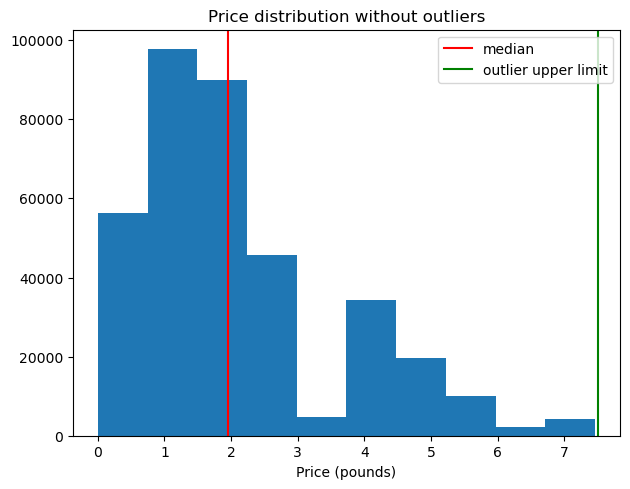

In [17]:
# Price histogram plotting
plt.hist(ot.price[ot['price'] < up_lim_price])
plt.axvline(x=Q2_price, color='red', label='median')
plt.axvline(x=up_lim_price, color='green', label='outlier upper limit')
plt.title("Price distribution without outliers")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Price (pounds)')

In [18]:
outlier_perc = round(ot[ot['price'] >= up_lim_price].shape[0] * 100 / ot.shape[0], 2)
print(f"{outlier_perc} % of my data are outliers on the price variable")

8.75 % of my data are outliers on the price variable


## To appling the k-means to segment my data I must handle the outliers because they affect the centroids' calculation from the method

### Let's explore seasonality in the data

In [19]:
# Setting up monthly, yearly, daily data
ot['invoice_year'] = ot['invoice_date'].dt.year
ot['invoice_month'] = ot['invoice_date'].dt.month
ot['invoice_weekday'] = ot['invoice_date'].dt.dayofweek
ot['invoice_dayname'] = ot['invoice_date'].dt.day_name()

In [20]:
# Defining color palette for plots
palette = sns.color_palette("tab10")

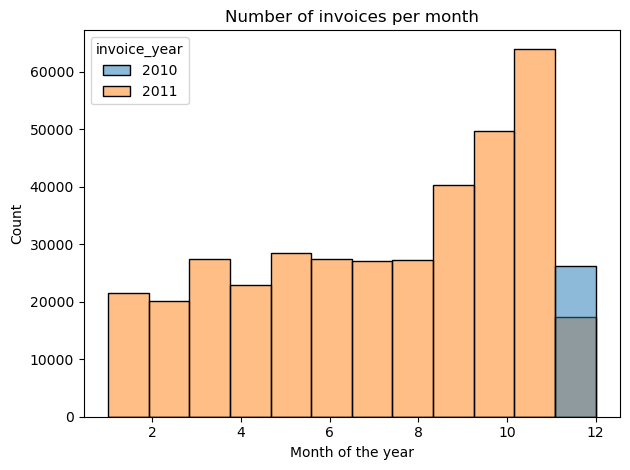

In [21]:
# Distribution of invoices per month
sns.histplot(data=ot, x='invoice_month', hue='invoice_year', bins=12, kde=False, palette=palette)
plt.title("Number of invoices per month")
plt.xlabel("Month of the year")
plt.tight_layout()
plt.savefig("../visualizations/invoice_month.png")

### The number of invoice has a boost from September on, having a peak on November (presumably because of Black Friday) reachig its lowest point on December 2011.

In [22]:
# To plot the days in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ot['invoice_dayname'] = pd.Categorical(ot['invoice_date'].dt.day_name(), categories=day_order, ordered=True)

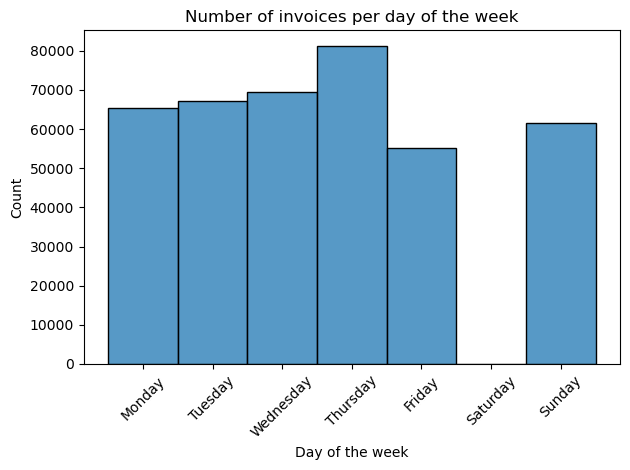

In [23]:
# Distributions of invoices per day of the week
sns.histplot(data=ot, x='invoice_dayname', multiple='stack', bins=12, kde=False)
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visualizations/invoice_weekday.png")

In [24]:
ot['invoice_dayname'].unique()

['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']

### The number of invoice has a peak on Thursdays. It is interesting that there is no data available for Saturdays

## Let's explore some KPIs

In [25]:
# Line Items (Number of products per invoice)
line_items = ot.groupby("invoice")['stock_code'].count()
print(f"On average, there are {round(line_items.mean())} stock codes per invoice")

On average, there are 18 stock codes per invoice


In [26]:
# Average order value per invoice
avg_order = ot.groupby("invoice").sum()['total_order_value']
print(f"The average purchase per invoice is {round(avg_order.mean(), 2)} pounds")

The average purchase per invoice is 380.18 pounds


In [27]:
# Average order value per customer
cust_spent = ot.groupby("customer_id").sum()['total_order_value']
print(f"In average the customer spent {round(cust_spent.mean(),2)} pounds from December 2010 to December 2011")

In average the customer spent 1899.01 pounds from December 2010 to December 2011


In [28]:
# Number of customers who spent more than the average
cust_above_avg = (cust_spent > cust_spent.mean()).sum() 
print(f"There are {cust_above_avg} customers (out of {ot['customer_id'].nunique()}) who spent more than the average customers")

There are 901 customers (out of 4362) who spent more than the average customers


In [29]:
# Average invoices per customer
inv_cust = ot.groupby('customer_id').count()['invoice']
print(f"The customers made on average {round(inv_cust.mean())} purchases")

The customers made on average 92 purchases


In [30]:
# How many customers are above the average invoice per customer?
print(f"There are {(inv_cust > inv_cust.mean()).sum()} customers who made more purchases than the average")

There are 1192 customers who made more purchases than the average


In [31]:
# filtering the data by month and year
idx_month_year = (ot['invoice_month'] == 11) & (ot['invoice_year'] == 2011) 
ot[idx_month_year].groupby("customer_id").agg({'invoice': 'count', 'stock_code': 'nunique'}).sort_values(by='invoice', ascending=False)

,invoice,stock_code
customer_id,,
u14096,1894,836
u12748,1598,885
u17841,1369,579
u14911,937,568
u16549,502,303
...,...,...
u14235,1,1
u1808,1,1
u14292,1,1


### For the top 5 customers/products check the purchases on time.

### Let's explore the data grouped by customer

In [32]:
cust_data = pd.DataFrame()
cust_group = ot.groupby('customer_id')

In [33]:
# Let's define customer loyalty as the difference in time between the 1st and the last purchase
delta_date = (ot.groupby('customer_id').first()['invoice_date'] - ot.groupby('customer_id').last()['invoice_date']).abs()
cust_data['loyalty_time'] = delta_date.dt.days

In [34]:
once_cust = cust_data[cust_data['loyalty_time'] == 0].shape[0]
print(f"There are {once_cust} customer with less than 1 day of loyalty. This represent {round(once_cust *100 / cust_data.shape[0])}% of the total clients")

There are 1566 customer with less than 1 day of loyalty. This represent 36% of the total clients


In [35]:
print(f"The average loyalty time of the clients is {round(cust_data['loyalty_time'].mean())} days")
round(cust_data['loyalty_time'].min()), round(cust_data['loyalty_time'].max())

The average loyalty time of the clients is 130 days


(0, 373)

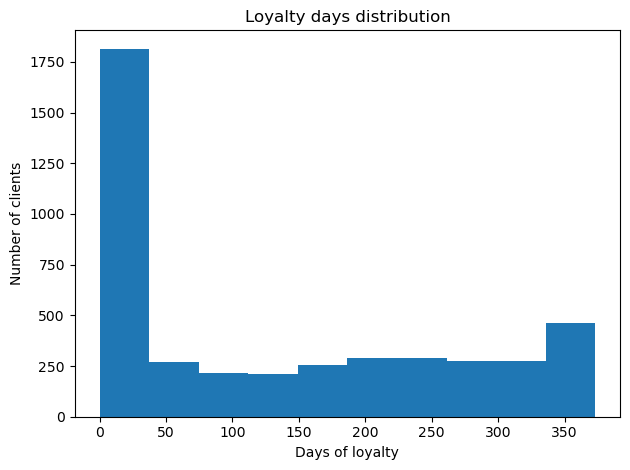

In [36]:
plt.hist(cust_data['loyalty_time'])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution_cust_onlyonce.png")

### Excluding the once in a life time clients the distribution of loyalty days is shown below

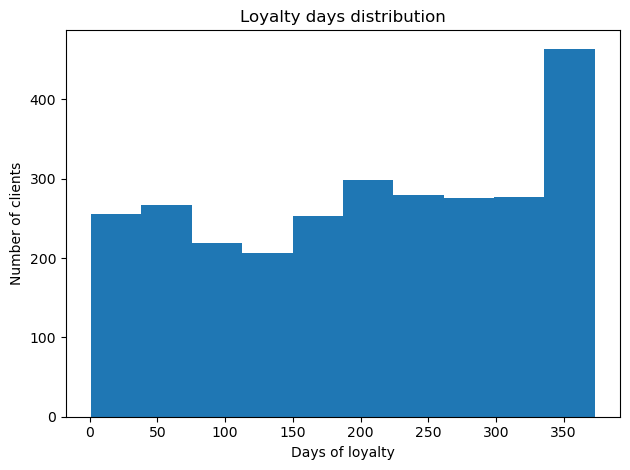

In [37]:
plt.hist(cust_data['loyalty_time'][cust_data.sort_values(by='loyalty_time', ascending=False)['loyalty_time']>0])
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.savefig("../visualizations/loyalty_distribution.png")

### I will perform a customer segmentation considering just the transactions without any return. Therefore, I will create two new datasets. The first one excluding the returned transactions and the second one with just the returned transactions.

In [38]:
# Grouping the data by customer and stock code to get the transactions with their returns
invoice_list = ot.groupby(['customer_id', 'stock_code']).agg({'invoice': list, 'quantity': 'sum'})
invoice_list = invoice_list[ot.groupby(['customer_id', 'stock_code'])['quantity'].sum() <= 0].reset_index()

In [39]:
invoice_idx = []
[invoice_idx.extend(ids) for ids in invoice_list['invoice']]
invoice_idx 

['C541433',
 '541431',
 '543370',
 'C549955',
 '573173',
 'C579178',
 '573173',
 'C579178',
 '573173',
 'C579178',
 'C565050',
 '563100',
 '543733',
 'C544419',
 '556127',
 'C562728',
 '556127',
 'C562728',
 'C574019',
 '563614',
 '543989',
 'C551348',
 '573656',
 'C575669',
 '564853',
 'C565294',
 'C579090',
 '577135',
 'C555046',
 '552956',
 'C555288',
 '554126',
 'C538723',
 'C538723',
 'C548729',
 '547659',
 'C538723',
 '541518',
 'C560219',
 '571255',
 'C571499',
 '571255',
 'C571499',
 'C571499',
 '571255',
 'C571499',
 '571255',
 'C571499',
 '571255',
 '571255',
 'C571499',
 'C571499',
 '571255',
 'C571499',
 '571255',
 '571255',
 'C571499',
 'C571499',
 '571255',
 '571255',
 'C571499',
 '571255',
 'C571499',
 'C571499',
 '571255',
 '571255',
 'C571499',
 'C571499',
 '571255',
 '571445',
 'C572479',
 'C572479',
 'C539644',
 'C539644',
 'C536548',
 'C536548',
 'C536548',
 '542215',
 'C548356',
 'C536548',
 'C536548',
 'C536548',
 'C536548',
 'C555881',
 '555162',
 '555162',
 'C55

In [40]:
returns = ot[ot['invoice'].isin(invoice_idx)]

In [41]:
# Dataset without returns
online_trans = ot.drop(returns.index, axis=0).reset_index()

In [42]:
online_trans

,index,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,total_order_value,invoice_year,invoice_month,invoice_weekday,invoice_dayname
0,0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,2010,12,2,Wednesday
1,2,536381,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,2010,12,2,Wednesday
2,3,536384,22469,HEART OF WICKER SMALL,40,2010-12-01 09:53:00,1.45,u18074,United Kingdom,58.00,2010,12,2,Wednesday
3,4,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,1,2010-12-01 09:56:00,19.95,u1742,United Kingdom,19.95,2010,12,2,Wednesday
4,5,536389,22193,RED DINER WALL CLOCK,2,2010-12-01 10:03:00,8.50,u12431,Australia,17.00,2010,12,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369576,399802,581579,23480,MINI LIGHTS WOODLAND MUSHROOMS,8,2011-12-09 12:19:00,3.75,u17581,United Kingdom,30.00,2011,12,4,Friday
369577,399803,581580,23334,IVORY WICKER HEART SMALL,4,2011-12-09 12:20:00,0.63,u12748,United Kingdom,2.52,2011,12,4,Friday
369578,399804,581580,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-12-09 12:20:00,2.95,u12748,United Kingdom,2.95,2011,12,4,Friday
369579,399805,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-12-09 12:31:00,1.95,u15804,United Kingdom,23.40,2011,12,4,Friday


In [43]:
print(f"{round((ot.shape[0] - online_trans.shape[0]) * 100 / ot.shape[0], 2)} % are returns whose transaction were made in the time interval of the data")

7.56 % are returns whose transaction were made in the time interval of the data


In [44]:
# The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data
retunr_wt_trans = online_trans[online_trans['quantity']<= 0]

### The negative values on the remaining data are considered return whose transactions were done outside the time interval of the data

In [45]:
print(f"{round(retunr_wt_trans.shape[0] * 100 / ot.shape[0], 2)}% are returns without quivalent transaction on the time interval of the data. These transactions are gonna be dropped from the data")

1.1% are returns without quivalent transaction on the time interval of the data. These transactions are gonna be dropped from the data


In [46]:
# Dropping returned data without transaction on the time interal of the dataframe
online_trans.drop(retunr_wt_trans.index, axis=0, inplace=True)

In [47]:
# Changing the name of the index column to stress that it is the index of the data with returns
online_trans.rename(columns={'index': 'old_index'}, inplace=True)